In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import math
pd.options.mode.chained_assignment = None

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from preprocess.functions.date_inspector import load_files
from functions.eda import show_correlation, show_normalized_mutual_information, show_relative_density_plot, relative_density_plot, max_density_plot

In [3]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'kma'))
print(data_dir)

/home/jeon/Desktop/kpx/data/raw/kma


In [4]:
df_kpx_forecast=pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_kpx_forecast_ma.pkl')))

In [5]:
## Distribution plot of each column
def dist_plot(df):
    for idx, column in enumerate(df.columns) :
        if idx%3 == 0:
            plt.figure(figsize=(15, 3))
        plt.subplot(1, 3, (idx%3)+1)
        plt.title(column)
        try : 
            sns.distplot(df[column].interpolate(method='linear')) # due to few NA existing
        except Exception as e :
            print(e)
        if idx%3 == 2 :
            plt.show()

In [6]:
def polar_histogram(y, title) :
    degrees = y
    radians = np.deg2rad(degrees)
    
    bin_size = 10
    a, b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    plt.title(title)
    plt.show()
    
    return

In [7]:
import math

def wind_cos_sin(df):
    wind_dir = df['Wind Direction(16)']
    wind_dir_deg = np.deg2rad(wind_dir)

    wind_dir_cos = wind_dir_deg.apply(math.cos)
    wind_dir_sin = wind_dir_deg.apply(math.sin)

    df['wind_dir_cos'] = wind_dir_cos#.round(1)
    df['wind_dir_sin'] = wind_dir_sin#.round(1)
    
    return df

def new_wind_speed_direction(df,phi):
    theta = df['Wind Direction(16)']
    wind_speed = df['Wind Speed(m/s)']
    deg = theta - phi

    cos_deg = np.deg2rad(deg).apply(math.cos)

    new_wind_speed = wind_speed*(cos_deg**2)

    df['new_wind_speed_square'] = new_wind_speed#.round(1)
    
    return df

# 예보 데이터

In [8]:
df = df_kpx_forecast.copy()

#### 발전량 데이터

In [9]:
df.columns

Index(['date', 'date(forecast)', 'datetime', 'datetime(forecast)', 'location',
       'Weather Condition', 'Wind Speed(m/s)', 'Humidity(%)', 'Celsius(°C)',
       'Wind Direction(16)', 'Rainfall Probability', 'Rainfall', 'Snowfall',
       'Celsius(Highest)', 'Celsius(Lowest)', 'Power Generation(kW)+0',
       'Power Generation(kW)+1', 'Power Generation(kW)+2', 'year', 'month',
       'day', 'hour', 'ma48_0', 'ma96_0', 'ma600_0', 'ma48_1', 'ma96_1',
       'ma600_1', 'ma48_2', 'ma96_2', 'ma600_2'],
      dtype='object')

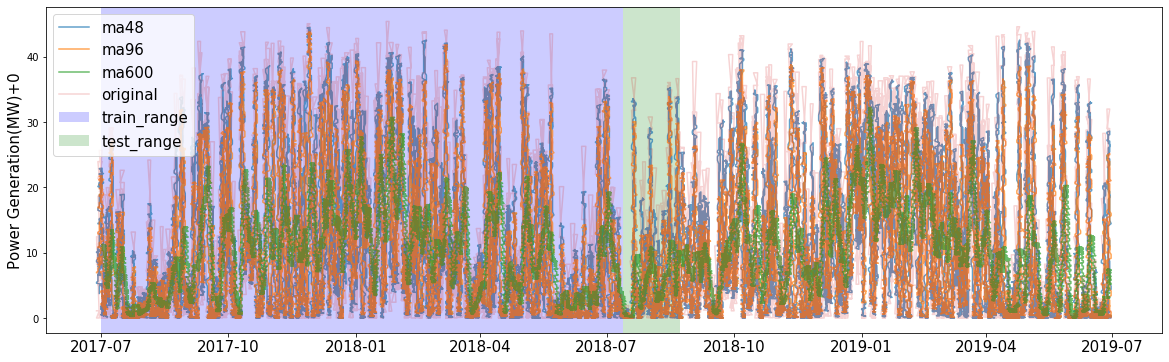

In [10]:
import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

df_temp = df.copy().reset_index(drop=True)
df_temp['Power Generation(kW)+0'] = df_temp['Power Generation(kW)+0']/1000
range = df_temp.shape[0]
x = df_temp['date']
x_vline = datetime.datetime
plt.figure(figsize=(20, 6))
# plt.plot(x, df_temp['Power Generation(kW)'].iloc[0:range].rolling(12).mean(), label='ma12', alpha=0.7)
plt.plot(x, df_temp['Power Generation(kW)+0'].iloc[0:range].rolling(48).mean(), label='ma48', alpha=0.7)
# plt.plot(x, df_temp['Power Generation(kW)'].iloc[0:range].rolling(40).mean(), label='ma48', alpha=0.7)
plt.plot(x, df_temp['Power Generation(kW)+0'].iloc[0:range].rolling(96).mean(), label='ma96', alpha=0.7)
# plt.plot(x, df_temp['Power Generation(kW)'].iloc[0:range].rolling(150).mean(), label='ma150', alpha=0.7)
plt.plot(x, df_temp['Power Generation(kW)+0'].iloc[0:range].rolling(600).mean(), label='ma600', alpha=0.7)

#plt.plot(df_temp['Power Generation(kW)'].iloc[0:range].rolling(1500).mean(), label='ma1500', alpha=0.7)

plt.plot(x, df_temp['Power Generation(kW)+0'].iloc[0:range], label ='original', alpha=0.2)

a=datetime.datetime(2017,7,1)
b=datetime.datetime(2018,7,13)
c=datetime.datetime(2018,8,23)
d=datetime.datetime(2018,10,1)
#d=datetime.datetime(2019,6,30)

# plt.axvline(x=a)
# plt.axvline(x=b)

plt.axvspan(a,b, facecolor='blue',alpha=0.2, label='train_range')
plt.axvspan(b,c, facecolor='green',alpha=0.2, label='test_range')
#plt.axvspan(c,d, facecolor='blue',alpha=0.2)#, label='train_range')
#plt.axvspan(a,b, facecolor='blue',alpha=0.1)#, label='train_range')
plt.xticks(fontsize=15)
plt.ylabel('Power Generation(MW)+0', fontsize=15)
plt.legend(fontsize=15)

plt.show()

### wind direction

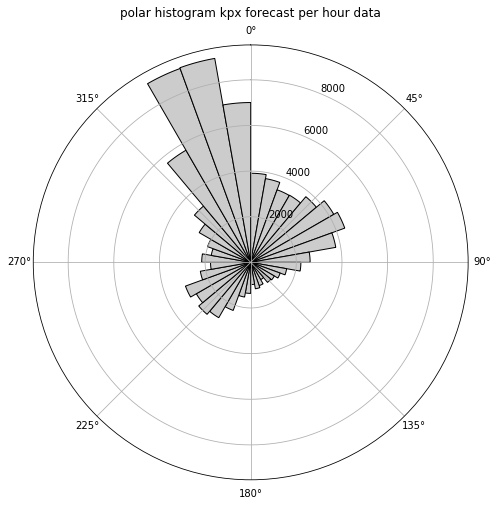

In [11]:
polar_histogram(df['Wind Direction(16)'], 'polar histogram kpx forecast per hour data')

### correlation

[Correlation : Descending Order]
ma600_1  ma600_0    0.999979
ma600_2  ma600_1    0.999979
         ma600_0    0.999919
ma96_1   ma96_0     0.999678
ma96_2   ma96_1     0.999671
dtype: float64

[Correlation : Ascending Order]
ma600_0  Celsius(Highest)   -0.721208
ma600_1  Celsius(Highest)   -0.720672
ma600_2  Celsius(Highest)   -0.720150
ma600_0  Celsius(°C)        -0.685940
ma600_1  Celsius(°C)        -0.685393
dtype: float64


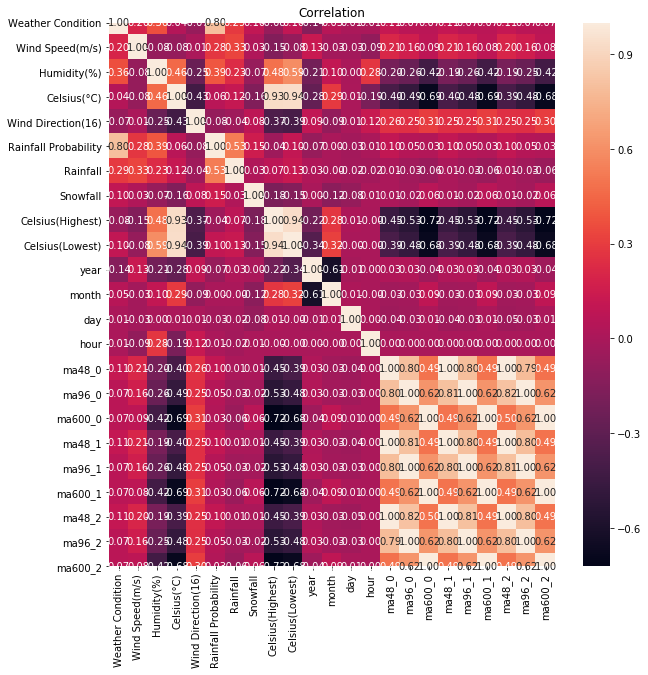

In [12]:
show_correlation(df)

### Normalized mutual information / Relative density plot

[Normalized Mutual Information : Descending Order]
ma48_1   ma48_0     0.999714
ma48_2   ma48_1     0.999598
ma96_1   ma96_0     0.999594
ma600_2  ma600_1    0.999539
ma48_2   ma48_0     0.999488
dtype: float64


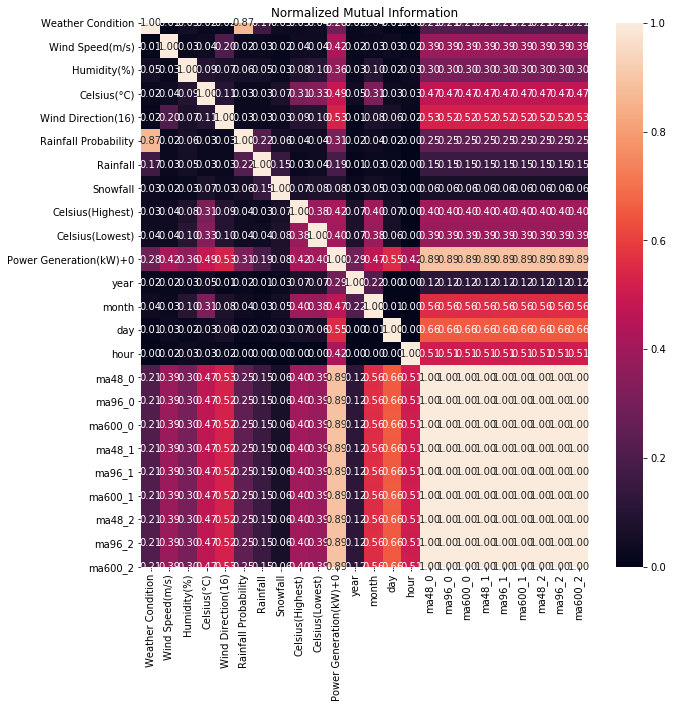

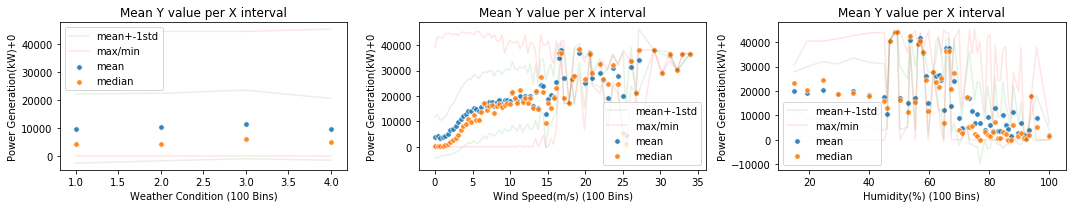

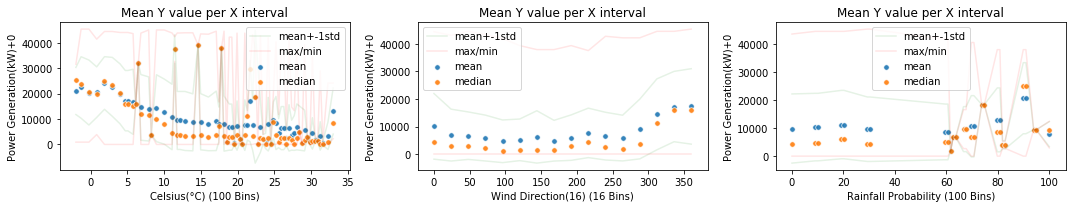

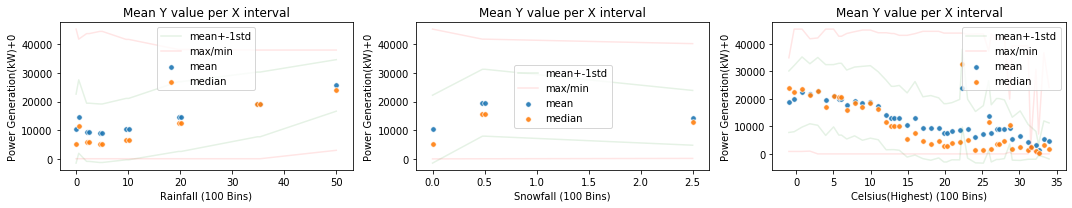

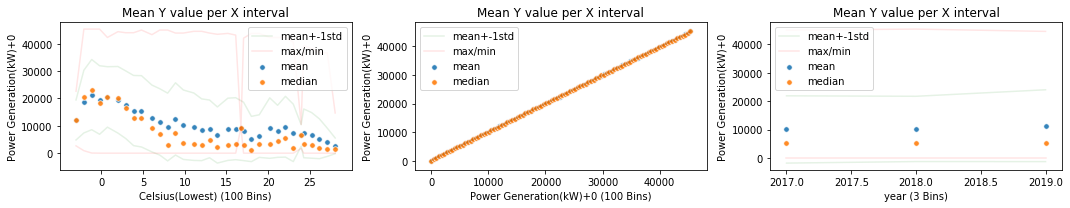

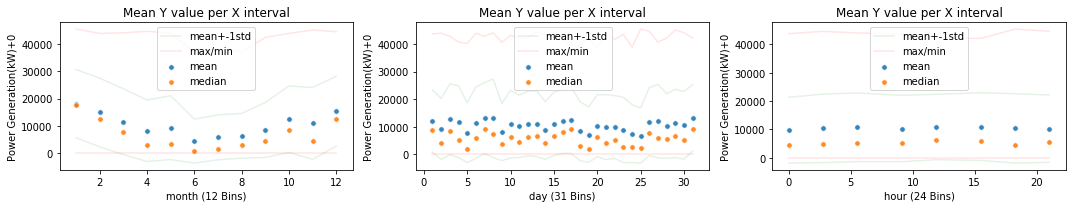

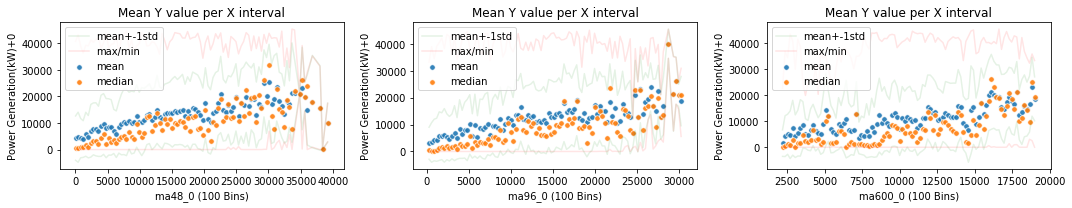

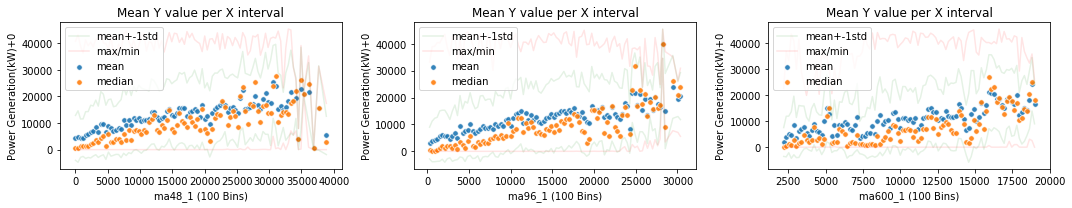

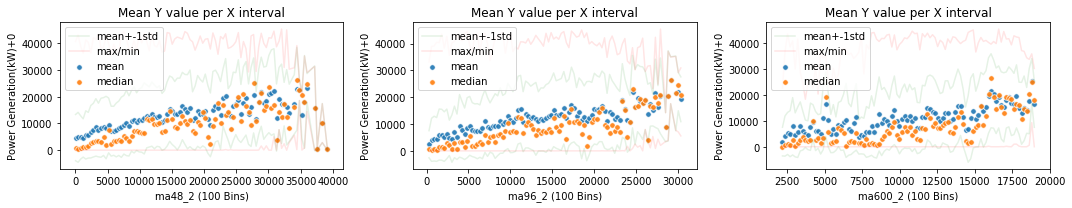

In [13]:
drop_val = ['date', 'date(forecast)', 'datetime', 'datetime(forecast)', 'location','Power Generation(kW)+1', 'Power Generation(kW)+2']
df_2 = df.drop(drop_val,axis=1)

show_normalized_mutual_information(df_2)

target = 'Power Generation(kW)+0'
show_relative_density_plot(df_2, target)

### distribution plot

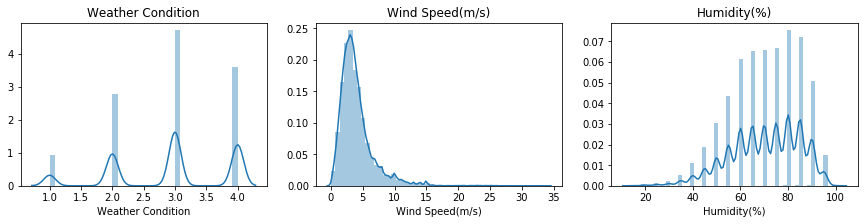

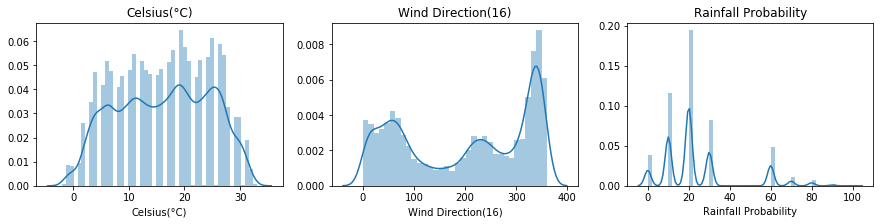

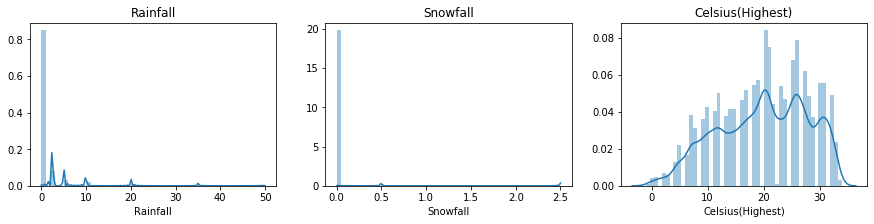

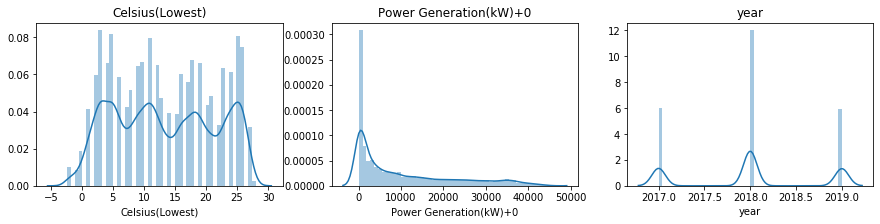

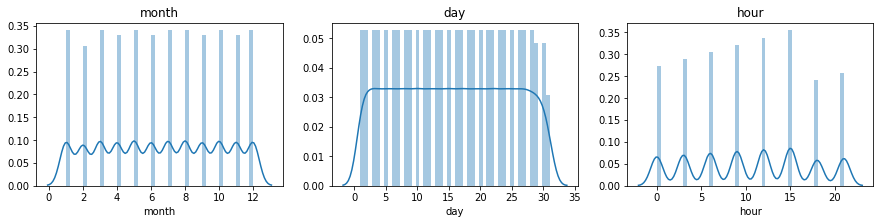

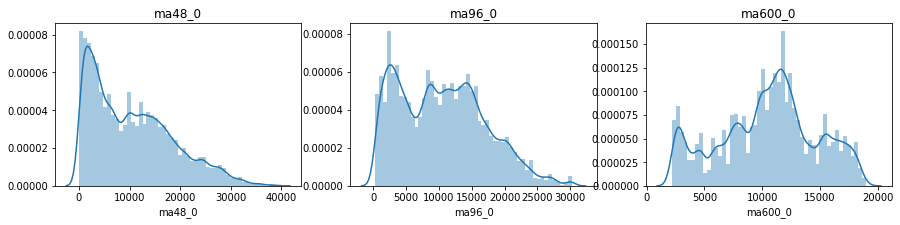

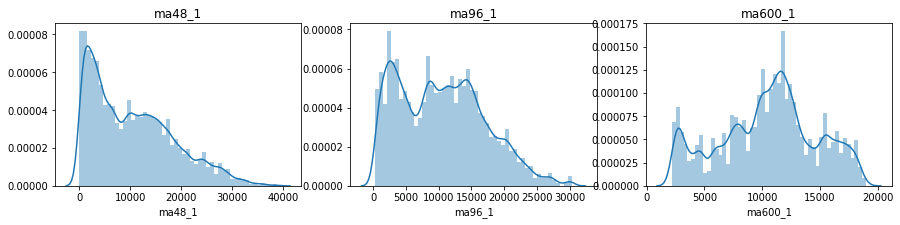

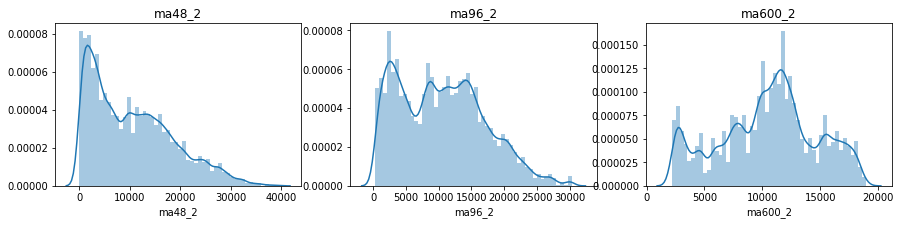

In [14]:
dist_plot(df_2)

### Windowing

In [15]:
#Windowing

def fe_add_timestep(df_original, num_timestep) : 
    
    num_timestep = num_timestep//3
    df = df_original.copy()
    df_shifted = df_original.copy()
    df_shifted = df_shifted.shift(num_timestep)

    ### previous, later 함수 대상으로는 돌지 않게
    lst = list(df.columns)
    lst2 = list(df.columns)
    for col in lst:
        if 'previous' in col :
            lst2.remove(col)
    for col in lst:
        if 'later' in col :
            lst2.remove(col)
    columns = lst2
    columns.remove('date')
    columns.remove('date(forecast)')
    columns.remove('datetime')
    columns.remove('datetime(forecast)')
    columns.remove('Power Generation(kW)+0')
    columns.remove('Power Generation(kW)+1')
    columns.remove('Power Generation(kW)+2')
    ######
    
    num_timestep = num_timestep*3
    for column in columns :
        df[column+' (previous %d)'%num_timestep] = df_shifted[column]
    df = df[df['Celsius(Lowest) (previous %d)'%num_timestep].notnull()]
    
    return df

In [16]:
df_3 = fe_add_timestep(df,48)

[Normalized Mutual Information : Descending Order]
ma48_1 (previous 48)   ma48_0 (previous 48)     0.999714
ma48_2 (previous 48)   ma48_1 (previous 48)     0.999598
ma96_1 (previous 48)   ma96_0 (previous 48)     0.999594
ma600_2 (previous 48)  ma600_1 (previous 48)    0.999539
ma48_2 (previous 48)   ma48_0 (previous 48)     0.999488
dtype: float64


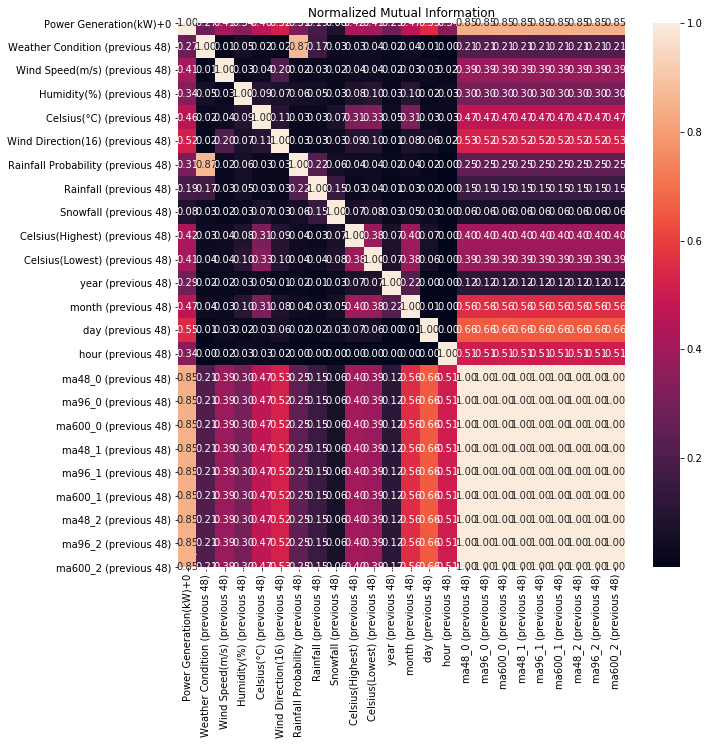

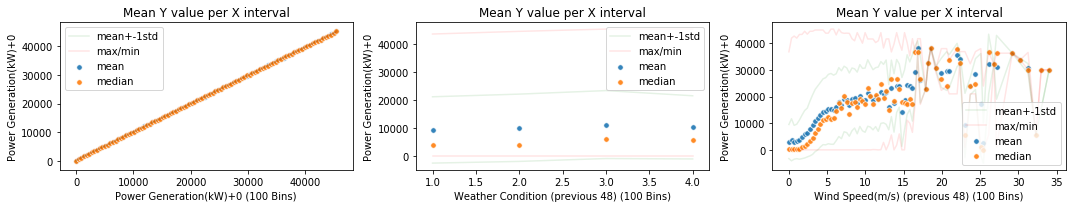

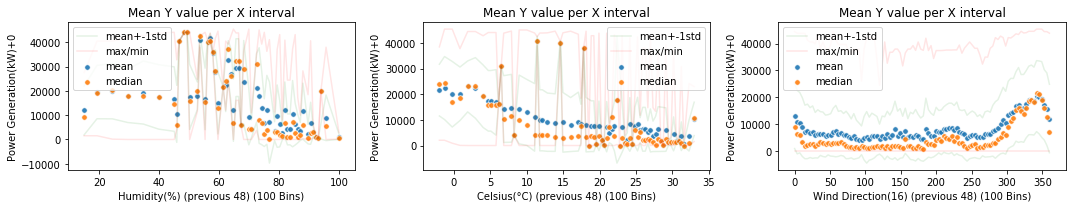

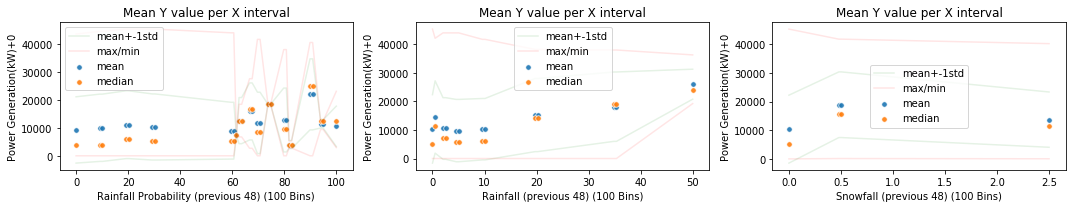

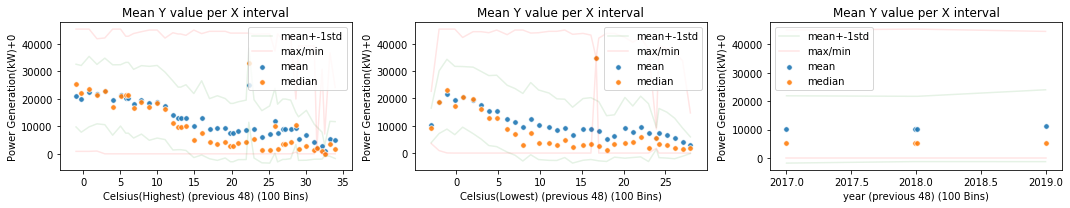

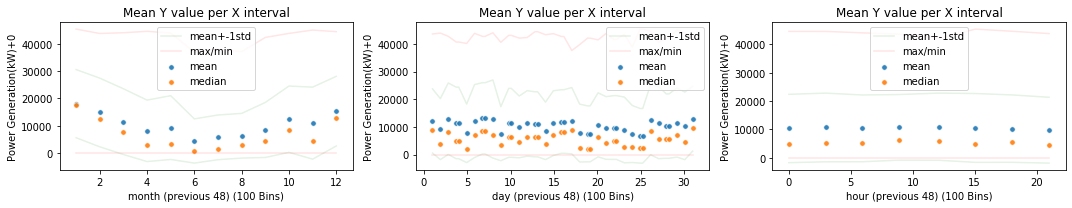

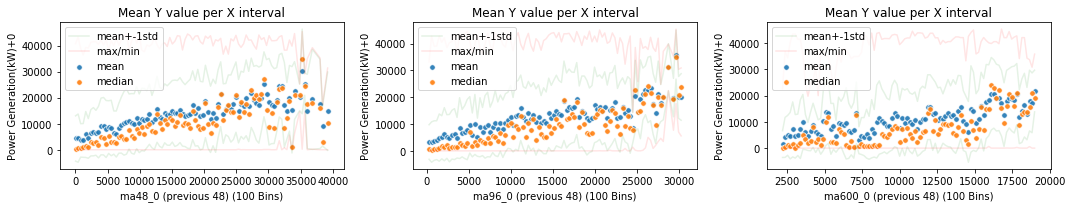

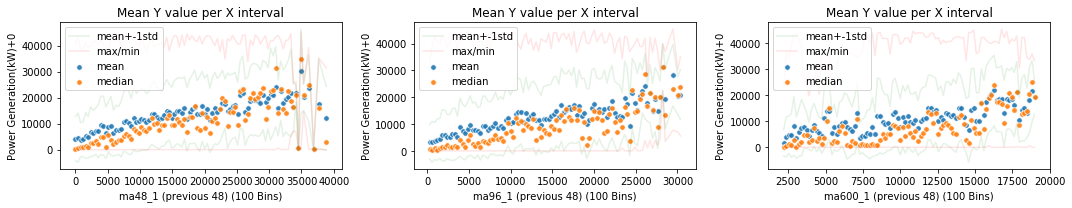

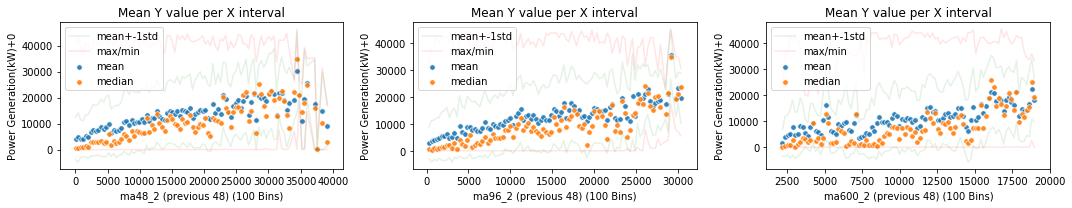

In [17]:
drop_val = ['date', 'date(forecast)', 'datetime', 'datetime(forecast)', 'location',
       'Weather Condition', 'Wind Speed(m/s)', 'Humidity(%)', 'Celsius(°C)',
       'Wind Direction(16)', 'Rainfall Probability', 'Rainfall', 'Snowfall',
       'Celsius(Highest)', 'Celsius(Lowest)',
       'Power Generation(kW)+1', 'Power Generation(kW)+2', 'year', 'month',
       'day', 'hour', 'ma48_0', 'ma96_0', 'ma600_0', 'ma48_1', 'ma96_1',
       'ma600_1', 'ma48_2', 'ma96_2', 'ma600_2', 'location (previous 48)']
df_2 = df_3.drop(drop_val,axis=1)

show_normalized_mutual_information(df_2)

target = 'Power Generation(kW)+0'
show_relative_density_plot(df_2, target)

# 타지역 예보 데이터

In [3]:
import pandas as pd
import os

In [5]:
df_kpx = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_kpx_forecast_merged.pkl')))
df_hk = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_hk1_forecast_merged.pkl')))
df_ss = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_ss1_forecast_merged.pkl')))

In [ ]:
df_kpx['location'] = 0
df_hk['location'] = 1
df_ss['location'] = 2

### 제주 한경 지역

In [ ]:
show_normalized_mutual_information(df_hk)
dist_plot(df_hk)

In [ ]:
target = 'Power Generation(kW)+0'
show_relative_density_plot(df_2.drop(['date','date(forecast)','datetime','datetime(forecast)','location'],axis=1), target)

# 특정 시간에 나온 예보만 보기
14시에 나온 예보

In [ ]:
df_kpx = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_kpx_forecast_merged.pkl')))
df_hk = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_hk1_forecast_merged.pkl')))
df_ss = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(),'..','data','df_ss1_forecast_merged.pkl')))

In [ ]:
df_kpx['location'] = 0
df_hk['location'] = 1
df_ss['location'] = 2

In [ ]:
def fe_add_previous_n_hours_mean_kpx(df_original, columns, how_long=17) :
    df = df_original.copy()
    
    for column in columns :
        df[column+'(12 hours mean)'] = 0
        for idx in range(how_long) :
           #print(idx)
            df[column+'(12 hours mean)'] += df[column].shift(idx+1)
        df[column+'(12 hours mean)'] /= how_long

        df[column+'(12 hours mean)'] = df[column+'(12 hours mean)'].astype(float).round(1)
    df = df[how_long:]    

    return df

In [ ]:
#Windowing

def fe_add_timestep(df_original, num_timestep) : 
    
    num_timestep = num_timestep//3
    df = df_original.copy()
    df_shifted = df_original.copy()
    df_shifted = df_shifted.shift(num_timestep)

    ### previous, later 함수 대상으로는 돌지 않게
    #print(‘df.columns’)
    #print(df.columns)
    lst = list(df.columns)
    lst2 = list(df.columns)
    for col in lst:
        if 'previous' in col :
            lst2.remove(col)
    for col in lst:
        if 'later' in col :
            lst2.remove(col)
    columns = lst2
    columns.remove('date')
    columns.remove('date(forecast)')
    columns.remove('datetime')
    columns.remove('datetime(forecast)')
    columns.remove('Power Generation(kW)+0')
    columns.remove('Power Generation(kW)+1')
    columns.remove('Power Generation(kW)+2')
    columns.remove('location')
    ######
    #print(‘df.columns removed’)
    #print()
    
    num_timestep = num_timestep*3
    for column in columns :
        df[column+' (previous %d)'%num_timestep] = df_shifted[column]
    df = df[df['Celsius(Lowest) (previous %d)'%num_timestep].notnull()]
    
    return df

In [ ]:
import math

def wind_cos_sin(df):
    wind_dir = df['Wind Direction(16)']
    wind_dir_deg = np.deg2rad(wind_dir)

    wind_dir_cos = wind_dir_deg.apply(math.cos)
    wind_dir_sin = wind_dir_deg.apply(math.sin)

    df['wind_dir_cos'] = wind_dir_cos#.round(1)
    df['wind_dir_sin'] = wind_dir_sin#.round(1)
    
    return df

def new_wind_speed_direction(df,phi):
    theta = df['Wind Direction(16)']
    wind_speed = df['Wind Speed(m/s)']
    deg = theta - phi

    cos_deg = np.deg2rad(deg).apply(math.cos)

    new_wind_speed = wind_speed*cos_deg

    df['new_wind_speed'] = new_wind_speed#.round(1)
    
    return df

In [ ]:
df_14_forecast_kpx = df_kpx_ma[df_kpx_ma['datetime'].dt.hour == datetime.datetime(2014,12,14,14,0).hour].copy()
df_ohter_forecast_kpx = df_kpx_ma[df_kpx_ma['datetime'].dt.hour != datetime.datetime(2014,12,14,14,0).hour].copy()

df_14_forecast_kpx = df_14_forecast_kpx.reset_index(drop=True)
df_ohter_forecast_kpx = df_ohter_forecast_kpx.reset_index(drop=True)

In [ ]:
df = df_14_forecast_kpx.copy()

In [ ]:
df_2 = wind_cos_sin(df)
df_3 = new_wind_speed_direction(df_2, 330).copy()

In [ ]:
df_14_forecast_kpx = df_3.copy() #풍향,풍속 인코딩 default
df = df_14_forecast_kpx.reset_index(drop=True)

In [ ]:
target = 'Power Generation(kW)+0'
show_relative_density_plot(df.drop(['date','date(forecast)','datetime','datetime(forecast)','location'],axis=1), target)